In [2]:
import os
import pandas as pd
import numpy as np
import pickle

from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import *

from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

import matplotlib.pyplot as plt
plt.style.use('seaborn')

---

### First, copy-paste the setup from the notebook that produced the pretrained classweights.
This time we load also the test-data into memory
(Note to self: learn how to make imports from other notebooks...)

In [6]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [7]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy"))
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy"))
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))
X_test = np.load(os.path.join("data", "Kdata", "X_test.npy"))
y_test = np.load(os.path.join("data", "Kdata", "y_test.npy"))

In [8]:
from keras import backend as K

# Custom metrics.
# Note that any metric is computed per batch during training
# (hence one needs large batches for it to make sense).
# Also, there is the implicit 0.5 treshold in the K.round function below

def macroPrec(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec


def macroRecall(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):
    
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) )
    
    return macroF1



# Custom loss functions
# No clippping or rounding as those are not differentiable
# Note to self: these functions are already taking into account class imbalances, so remeber
# not to set the class_weight argument in fitting method when using them as the loss 

# # semi macroF1
# def fuzzy_macroF1_flip(y_true, y_pred):

#     true_positives = K.sum(y_true * y_pred, axis=0)
    
#     actual_ones = K.sum(y_true, axis=0)
#     recall = true_positives / (actual_ones + K.epsilon())

#     positives = K.sum(y_pred, axis=0)
#     precision = true_positives / (positives + K.epsilon())
    
#     macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) ) 
    
#     return 1-macroF1


# # weighted categorical crossentropy
# def my_crossE(y_true, y_pred):
    
#     class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
#     weighted_entropy = K.mean(class_weights * class_entropy)
#     return -4E-4 * weighted_entropy  # arbitrary coefficient to make it close to [0-1] interval


# take average of the last two, because why not
def my_loss(y_true, y_pred):
    # return 0.5*(fuzzy_macroF1_flip(y_true, y_pred) + my_crossE(y_true, y_pred))
    
    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1p2 = K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = K.mean(class_weights * class_entropy)
    
    return 0.5 - macroF1p2 - 2E-4 * weighted_entropy

In [52]:
# auxiliary functions
    

# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history):
    
    plt.figure(figsize=(12, 5))
    
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, 3, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, 3, 2)
    markers = ['b', 'r',  'g', 'y', 'm', 'c', 'k']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history[metric]
        val_results = history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    lr = history['lr'] # learning rate
    plt.plot(x, lr, 'k', label='Learning rate')
    plt.title('Learning rate')  
    plt.legend()
    

# choose callbacks to be given in model.fit(...)
class WakeEmbedding(Callback):
    def __init__(self, rel_lr_treshold):
        self.rel_lr_treshold = rel_lr_treshold
    
    def on_train_begin(self, logs={}):
        self.init_lr =  K.eval(self.model.optimizer.lr)
        
    def on_epoch_begin(self, epoch, logs={}):
        lr =  K.eval(self.model.optimizer.lr)
        if (lr / self.init_lr) <= self.rel_lr_treshold:
            self.model.layers[0].trainable = True
        print("Embedding trainable:", self.model.layers[0].trainable)

        
callbacks = [ReduceLROnPlateau(factor=0.9, patience = 1),
             EarlyStopping(monitor='val_macroF1', mode='max', patience=2),
            WakeEmbedding(0.9)
           ]


# some other global learning settings

batch_size = 3000
# defualt lr = 0.001
optimizer = optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999,\
                            epsilon=None, decay=0.0, amsgrad=False)
my_metrics = [macroPrec, macroF1, macroRecall] #, my_crossE, fuzzy_macroF1_flip, my_loss]

---

In [53]:
# the workhorse

class BlackBox():
    
    def __init__(self, layers, loss, metrics, callbacks=callbacks, class_weight=class_weights, epochs=epochs,\
                 embedd = None, embedd_dims=[None]*3, train_weights=False):
        
        self.layers = layers
        self.loss = loss
        self.metrics = metrics
        self.callbacks = callbacks
        self.class_weight = class_weight
        self.epochs = epochs
        self.train_weigts = train_weights
        self.history = None
        self.test_results = None
        
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            with open(embedd, "rb") as f:
                self.embedd_weights = pickle.load(f)
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=self.train_weigts))
            self.model.layers[0].trainable = self.train_weigts  # szczeżonego panbug szczeże
            
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
    
    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs=50):
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=self.class_weight,
            epochs=self.epochs,
            batch_size=batch_size,
            #validation_split=0.1,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = 1        
            )
        
    def reset(self):
        
        self.history = None
        self.test_results = None
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        
    def evaluate(self, X_test, y_test):
        print(f'Loss function: {self.loss.__name__ if callable(self.loss) else self.loss}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        self.test_results = self.model.evaluate(X_test, y_test)
        return self.test_results
    
    def plot(self):
        plot_history(self.history.history)
        
    def save_embedd(self, name):
        file = os.path.join("my_embeddings", f"weights_{name}.p")
        with open(file, 'wb') as f:
            pickle.dump(self.model.layers[0].get_weights(), f)
        
    def Ksave(self, name):
        file = os.path.join("my_embeddings", f"Kmodel_from_{name}.h5")
        self.model.save(file)
    
    def save_hist(self, name):
        file = os.path.join("my_embeddings", f"history_of_{name}.p")
        with open(file, 'w') as f:
            json.dump(self.history.history, f) 


In [54]:
custom_objects={'macroPrec': macroPrec,\
                'macroF1': macroF1,\
                'macroRecall': macroRecall,\
#                 'my_crossE': my_crossE,\
#                 'fuzzy_macroF1_flip': fuzzy_macroF1_flip,\
                'my_loss': my_loss
               }

---
---

In [ ]:
embedd_file = os.path.join("my_embeddings", "weights_50dim_GlblAvg_MyLoss_10epochs.p")

---
---

# Loss = *my_loss*

---

### Dense nets

In [56]:
# embedding: keras layer, trained
# structure: dense layers

layers1a = [Dense(50, activation='relu'),
           MaxPooling1D(4, 2),
           Dropout(0.1),
           Dense(50, activation='relu'),
            MaxPooling1D(4, 2),
           Dropout(0.1),
            Flatten()
          ]

model1a = BlackBox(layers=layers1a, loss=my_loss, metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length])
model1a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dense_26 (Dense)             (None, 679, 50)           2550      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 338, 50)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 338, 50)           0         
_________________________________________________________________
dense_27 (Dense)             (None, 338, 50)           2550      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 168, 50)           0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 168, 50)           0         
__________

In [57]:
model1a.fit() # my_loss

Train on 500000 samples, validate on 200000 samples
Epoch 1/20
Embedding trainable: False
500000/500000 [==============================] - 937s 2ms/step - loss: 0.1930 - macroPrec: 0.7427 - macroF1: 0.7609 - macroRecall: 0.8095 - val_loss: 0.1822 - val_macroPrec: 0.7545 - val_macroF1: 0.7812 - val_macroRecall: 0.8259
Epoch 2/20
Embedding trainable: False
500000/500000 [==============================] - 977s 2ms/step - loss: 0.1572 - macroPrec: 0.7711 - macroF1: 0.8062 - macroRecall: 0.8596 - val_loss: 0.1800 - val_macroPrec: 0.7573 - val_macroF1: 0.7855 - val_macroRecall: 0.8263
Epoch 3/20
Embedding trainable: False
500000/500000 [==============================] - 978s 2ms/step - loss: 0.1508 - macroPrec: 0.7800 - macroF1: 0.8148 - macroRecall: 0.8662 - val_loss: 0.1852 - val_macroPrec: 0.7705 - val_macroF1: 0.7882 - val_macroRecall: 0.8158
Epoch 4/20
Embedding trainable: True
500000/500000 [==============================] - 988s 2ms/step - loss: 0.1461 - macroPrec: 0.7878 - macroF1: 0

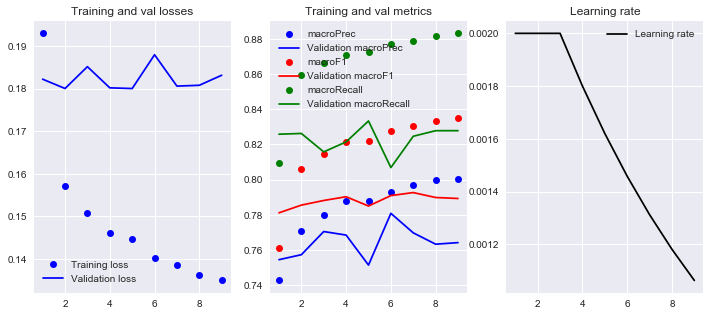

In [58]:
model1a.plot()

---

### Convolutions

In [59]:
# embedding: keras layer, trained
# structure: convolution layers

layers2a = [Conv1D(40, 4),
            MaxPooling1D(4, 2),
            Dropout(0.1),
            Conv1D(40, 4),
            MaxPooling1D(4, 2),
            Dropout(0.1),
            Flatten()
           ]

model2a = BlackBox(layers=layers2a, loss=my_loss, metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length])
model2a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 676, 40)           8040      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 337, 40)           0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 337, 40)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 334, 40)           6440      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 166, 40)           0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 166, 40)           0         
__________

In [60]:
model2a.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/20
Embedding trainable: False
500000/500000 [==============================] - 1408s 3ms/step - loss: 0.1783 - macroPrec: 0.7559 - macroF1: 0.7885 - macroRecall: 0.8485 - val_loss: 0.1853 - val_macroPrec: 0.7555 - val_macroF1: 0.7839 - val_macroRecall: 0.8267
Epoch 2/20
Embedding trainable: False
500000/500000 [==============================] - 1407s 3ms/step - loss: 0.1466 - macroPrec: 0.7862 - macroF1: 0.8210 - macroRecall: 0.8737 - val_loss: 0.1819 - val_macroPrec: 0.7620 - val_macroF1: 0.7898 - val_macroRecall: 0.8350
Epoch 3/20
Embedding trainable: False
500000/500000 [==============================] - 1405s 3ms/step - loss: 0.1407 - macroPrec: 0.7933 - macroF1: 0.8279 - macroRecall: 0.8780 - val_loss: 0.1946 - val_macroPrec: 0.7867 - val_macroF1: 0.7913 - val_macroRecall: 0.8055
Epoch 4/20
Embedding trainable: True
500000/500000 [==============================] - 1407s 3ms/step - loss: 0.1368 - macroPrec: 0.7999 - macroF

---

### Recurrent NNEts

In [61]:
# embedding: keras layer, trained
# structure: birectional fully connected RNN layer + dense

layers3a = [Bidirectional(SimpleRNN(130, dropout=0.1, recurrent_dropout=0.1)),
            Dense(30, activation='relu')
           ]

model3a = BlackBox(layers=layers3a, loss=my_loss, metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length])
model3a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 679, 50)           13865200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 260)               47060     
_________________________________________________________________
dense_30 (Dense)             (None, 30)                7830      
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 186       
Total params: 13,920,276
Trainable params: 55,076
Non-trainable params: 13,865,200
_________________________________________________________________


In [62]:
model3.plot()

NameError: name 'model3' is not defined

---

### Short-Long-Term-Memory

In [ ]:
# embedding: keras layer, trained
# structure: birectional fully connected RNN layer + dense

layers4a = [Bidirectional(LSTM(60, dropout=0.1, recurrent_dropout=0.1)),
            Dense(20, activation='relu')
           ]

model4a = BlackBox(layers=layers4a, loss=my_loss, metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length])
model4a.summary()

In [ ]:
model4.plot()

---
---

# Loss = ...

---

### Dense nets

---

---

---